<a href="https://colab.research.google.com/github/cporrasn/practices_tutorials/blob/main/Profile_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Boltzmann learning of a profile model


## 0) Import packages

In [1]:
import numpy as np
from numpy.random import choice
from matplotlib import pyplot as plt
import scipy.stats as sc

## 1) Process data

### 1.1) Import MSA

The format of the data is **.fasta**: 
* sequence  *descriptions* start with '**>**' and are followed by <font color = black > sequences </font>  on the next line. 
* sequences are *aligned*, that means that they have been preprocessed to all have the same length and the same patterns in the same position


<b>Note:</b> "-" gaps are used to align the data and are treted as any other amino acid in our models. Usually they are found at the extremes of the sequences. 


In [2]:
!git clone https://github.com/barthelemymp/Tutorials.git

Cloning into 'Tutorials'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 23 (delta 2), reused 8 (delta 0), pack-reused 0
Unpacking objects: 100% (23/23), done.


In [3]:
datapath = "Tutorials/Tutorial1/"
# read data 
data = open(datapath+'PF00014_train', 'r')
seqs_tmp = data.readlines()
data.close()

# see data
seqs_tmp[:10]

['>1\n',
 '-CLDELHPGRCSNYVERWYYDRGTKKCRSFQYGGCGGNRNHFYSKENCIFHC-\n',
 '>2\n',
 'MCMEPLVSGTGEAALNRFAYNALTRQCLPFVYSGIGGNQNNFLSKASCEASC-\n',
 '>3\n',
 'ACKLLQDIGPCKASVTRWSFDMSKGECVQFNYGGCKGNANNFESKEICEDRC-\n',
 '>4\n',
 '-CMLPVRHGNCNHEAQRWHFDFKNYRCTPFKYRGCEGNANNFLSENACRTACM\n',
 '>5\n',
 'VCSQPLVIGNGNGNVTRWYADPEDQRCKPFTYSGSGGTQNNFLTKEECESSCR\n']

**EX.1** We want to keep only the sequences. How do you do it? Save results in a variable called `seqs_my`.

In [4]:
#@title SOL.1
# remove sequence descriptions
seqs = [seqs_tmp[2*i + 1][:-1] for i in range( int( len(seqs_tmp) /2 ) )]

# see data
seqs[:5]

['-CLDELHPGRCSNYVERWYYDRGTKKCRSFQYGGCGGNRNHFYSKENCIFHC-',
 'MCMEPLVSGTGEAALNRFAYNALTRQCLPFVYSGIGGNQNNFLSKASCEASC-',
 'ACKLLQDIGPCKASVTRWSFDMSKGECVQFNYGGCKGNANNFESKEICEDRC-',
 '-CMLPVRHGNCNHEAQRWHFDFKNYRCTPFKYRGCEGNANNFLSENACRTACM',
 'VCSQPLVIGNGNGNVTRWYADPEDQRCKPFTYSGSGGTQNNFLTKEECESSCR']

### 1.2) Compute single site frequencies

In [5]:
# get M and L
M = np.size(seqs)
L = len(seqs[0])
q = 21
print(f"M = {M}, L = {L} \n")

    
# dictionary to convert the amino acids letters into integer numbers
letter2number = {  '-': 20,'A': 0, 'C': 1, 'D':2, 'E':3, 'F':4, 'G':5,'H':6,'I':7,'K':8,'L':9,'M':10,
       'N':11,'P':12,'Q':13,'R':14,'S':15,'T':16,'V':17, 'W':18, 'Y':19 }
;

M = 3000, L = 53 



''

**EX.2** Convert amino acids into numbers for the whole MSA

In [6]:
#@title SOL.2
# convert amino acids chars to numbers
sequences = np.zeros((M,L)).astype(int)
for m in range (M):
    for i in range (L):
        sequences[m,i]=letter2number[seqs[m][i]]  

# see data 
sequences[:5]

array([[20,  1,  9,  2,  3,  9,  6, 12,  5, 14,  1, 15, 11, 19, 17,  3,
        14, 18, 19, 19,  2, 14,  5, 16,  8,  8,  1, 14, 15,  4, 13, 19,
         5,  5,  1,  5,  5, 11, 14, 11,  6,  4, 19, 15,  8,  3, 11,  1,
         7,  4,  6,  1, 20],
       [10,  1, 10,  3, 12,  9, 17, 15,  5, 16,  5,  3,  0,  0,  9, 11,
        14,  4,  0, 19, 11,  0,  9, 16, 14, 13,  1,  9, 12,  4, 17, 19,
        15,  5,  7,  5,  5, 11, 13, 11, 11,  4,  9, 15,  8,  0, 15,  1,
         3,  0, 15,  1, 20],
       [ 0,  1,  8,  9,  9, 13,  2,  7,  5, 12,  1,  8,  0, 15, 17, 16,
        14, 18, 15,  4,  2, 10, 15,  8,  5,  3,  1, 17, 13,  4, 11, 19,
         5,  5,  1,  8,  5, 11,  0, 11, 11,  4,  3, 15,  8,  3,  7,  1,
         3,  2, 14,  1, 20],
       [20,  1, 10,  9, 12, 17, 14,  6,  5, 11,  1, 11,  6,  3,  0, 13,
        14, 18,  6,  4,  2,  4,  8, 11, 19, 14,  1, 16, 12,  4,  8, 19,
        14,  5,  1,  3,  5, 11,  0, 11, 11,  4,  9, 15,  3, 11,  0,  1,
        14, 16,  0,  1, 10],
       [17,  1, 15, 

**EX.3** Now define a function called  `fasta2matrix_my` that takes as input the path and return the matrix

**SOL.3**

In [7]:
# takes "path" of the MSA as input, and returns matrix
def fasta2matrix(path):
    
    data = open(path, 'r')
    seqs_tmp = data.readlines()
    data.close()
    
    seqs = [seqs_tmp[2*i + 1][:-1] for i in range( int( len(seqs_tmp) /2 ) )]
    
    M = np.size(seqs)
    L = len(seqs[0])
    
    
    sequences = np.zeros((M,L)).astype(int)
    for m in range (M):
        for i in range (L):
            sequences[m,i]=letter2number[seqs[m][i]]  
            
    return sequences

In [8]:
# initialize frequencies
counts_tmp = np.zeros((q, L)).astype(float)

# compute amino acid counts
for m in range(M):
    for i in range(L):
        amino = sequences[m][i]
        counts_tmp[amino][i] += 1
        
# normalize counts
freqs_tmp = counts_tmp / M 





# create a function out of that
def get_freqs(MSA, q = 21):
    M, L = np.shape(MSA)
    freqs_tmp = np.zeros((q, L)).astype(float)

    for m in range(M):
        for i in range(L):
            amino = MSA[m][i]
            freqs_tmp[amino][i] += 1

    return freqs_tmp / M     

**EX.4** Verify that the sum of the frequencies along the columns is 1

In [9]:
#@title SOL.4
sum(sum(freqs_tmp)) == L

True

In [10]:
# add pseucounts
pseudocount = 1/M
freqs = pseudocount/q + (1 - pseudocount) * freqs_tmp


## 2) Learn the model

In [11]:
## DEFINE USEFUL FUNCTIONS ##

# sample sequences from the model
def MC_sampler(model, nsample):
    q, L = np.shape(model) 
    seqs = choice(range(q), (nsample,L))
    
    for m in range(nsample):
        for site in range(L):
            a = sample_amino(model, site)
            seqs[m][site] = a
    return seqs

# normalize vector to 1    
def normalize(vec):
    return vec/np.sum(vec)

# sample single amino acid
def sample_amino(model, site):
    q, L = np.shape(model)
    p = normalize(np.exp(model[:, site]))
    return choice(range(q),  p = p)
        

### 2.1) Define learning functions

**EX.5** We need to implement the function performing Boltzmann learning. Name it `learn_model_my`

Input: 
- `freqs`: empirical frequencies




Parameters:
- `lr`: learning rate
- `nsample`: number of samples needed to estimate the model frequencies
- `t_learn`: number of iterations


Output:
- `model`: matrix(q, L)


In [ ]:
#@title SOL.5
def learn_model(freqs, lr = 0.1, nsample = 50, t_learn = 50):
    q, L = np.shape(freqs) 
    model = 0.0 * np.zeros((q, L))

    err_vec = np.zeros(t_learn)
    
    for t in range(t_learn):
        sample = MC_sampler(model, nsample) 
        freqs_MC = get_freqs(sample)
        model += lr*(freqs - freqs_MC)
        
        err_vec[t]  = sum(sum( (freqs - freqs_MC)**2 ))
    return model, err_vec



#### Let's learn our first model!!

In [ ]:
# define learning paramters
lr = 0.05
nsample = 100
t_learn = 15

# learn the model
model, err = learn_model(freqs, lr = lr, nsample = nsample, t_learn = t_learn)

### 2.2) Model error

Text(0, 0.5, 'Total error')

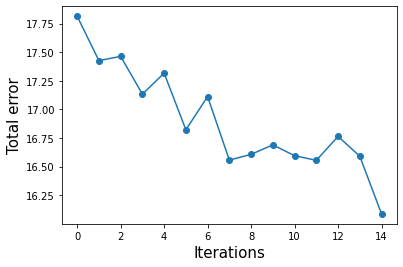

In [ ]:
plt.plot(range(0,t_learn, 1),  err[0:t_learn], marker = "o")
plt.xlabel("Iterations", fontsize = 15)
plt.ylabel("Total error", fontsize = 15)


**EX.6** The learning parameters don't seem well tunen. Change them smartly to achieve good learning in short time

**SOL.6** 


Good parameters:
- `lr`: 0.3
- `nsample`: 100
- `t_learn`: 100


In [ ]:
model, err = learn_model(freqs, lr = 0.3, nsample = 100, t_learn = 100)

### 2.3) Generative properties

In [ ]:
# sample sequences from the model (the funciton is a bit slow)
sequences_samp = MC_sampler(model, nsample = M)

# get frequencies
freqs_learned = get_freqs(sequences_samp)


Text(0, 0.5, 'Empirical frequencies ')

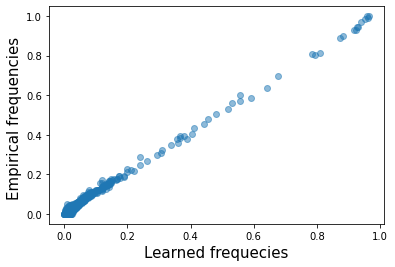

In [ ]:
# compare empirical and model frequencies
plt.scatter(freqs_learned, freqs, alpha = .5)
plt.xlabel("Learned frequecies", fontsize = 15)
plt.ylabel("Empirical frequencies ", fontsize = 15)

In [ ]:
# compute pearson correlation
sc.pearsonr( freqs.flatten(), freqs_learned.flatten())[0]

0.9967872143202352

In [ ]:
def gauge(matrix):
    matrix_copy = np.exp(np.copy(matrix))
    q, L = np.shape(matrix) 
    for site in range(L):
        matrix_copy[:, site] /= sum( matrix_copy[:, site]  )
    return np.log(matrix_copy)

# analytical value of the fields
h_emp = np.log(freqs)

# fix the gauge to compare them
h_emp_gauge = gauge(h_emp)
model_gauge = gauge(model)


Text(0, 0.5, 'Analytical fields ')

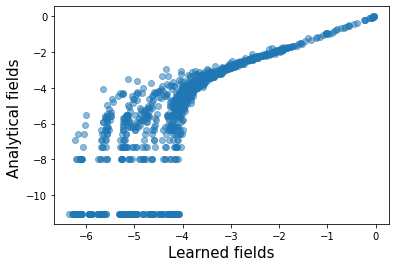

In [ ]:
plt.scatter(model_gauge.flatten(), h_emp.flatten(), alpha = .5)
plt.xlabel("Learned fields", fontsize = 15)
plt.ylabel("Analytical fields ", fontsize = 15)

## 3) Energies

**EX.7** Let's write down the function to compute sequence energy
`my_energy`

Input: 
- `freqs`: model
- `seq`: sequence

In [ ]:
#@title SOL.6
# energy of a sequence
def energy(model, seq):
    L = len(seq)
    E = 0
    for site in range(L):
        amino = seq[site]
        E += model[amino][site]
        
    return -E



### 3.1) Energy comparison

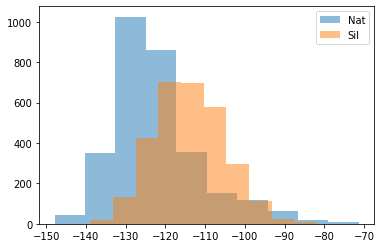

In [ ]:
# Compare the energies of the natural and of the generated sequences
plt.hist([energy(model, sequences[i, :]) for i in range(M)],
         alpha = 0.5, label = "Nat")
plt.hist([energy(model, sequences_samp[i, :]) for i in range(M)], 
         alpha = 0.5, label = "Sil")
plt.legend()

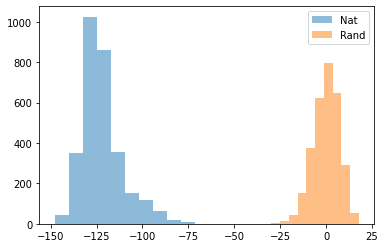

In [ ]:
#Let's compare the energies of randomly generated sequences with natural ones
plt.hist([energy(model, sequences[i, :]) for i in range(M)],
         alpha = 0.5, label = "Nat")
plt.hist([energy(model,  choice(range(q), (L))) for i in range(M)], 
         alpha = 0.5, label = "Rand")
plt.legend()

**EX.7** Compute energies for the test set sequences and verify that they are reasonable.

- Input file: `PF00014_test`

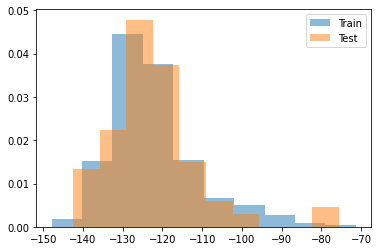

In [ ]:
#@title SOL.7
#Import test set and get dimensions
MSA_test = fasta2matrix(datapath+"PF00014_test")
M_test, L = np.shape(MSA_test)

#Replot train set energies
plt.hist([energy(model, sequences[i, :]) for i in range(M)],
         alpha = 0.5, label = "Train", density = True)

#Plot test set energies
plt.hist([energy(model, MSA_test[i, :] ) for i in range(M_test)], 
         alpha = 0.5, label = "Test", density = True)

#Generate legend
plt.legend()

### 3.2) Family assignment problem

Suppose to have a brand new sequence and you don't know its protein family. How would you exploit the model to guess it?

In [ ]:
# Import MSA's of two families to learn models
MSA_1 = fasta2matrix(datapath+"PF00014_train")
MSA_2 = fasta2matrix(datapath+"betalactam_train")

M, L = np.shape(MSA_1)

#Import MSA of test sequences
MSA_test = fasta2matrix(datapath+"test_mixed.fasta")

M_test, L = np.shape(MSA_test)

In [ ]:
model_1, _ = learn_model(get_freqs(MSA_1), lr = 0.3, nsample = 50, t_learn = 10)
model_2, _ = learn_model(get_freqs(MSA_2), lr = 0.3, nsample = 50, t_learn = 10)



In [ ]:
energy_test = [energy(model_1, MSA_test[i, :])  for i in range(M_test) ]
energy_train_1 = [energy(model_1, MSA_1[i, :])  for i in range(M) ]


**EX.8** Can you visualize the difference?

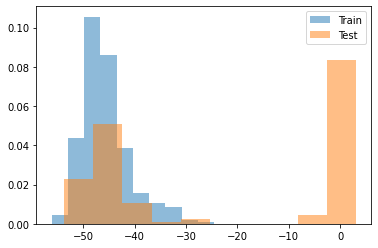

In [ ]:
#@title SOL.8
plt.hist(energy_train_1,density = True, alpha = 0.5, label = "Train")
plt.hist(energy_test,density = True, alpha = 0.5, label = "Test")
plt.legend()